<h1>Comment out the next cell if you want to use GPU</h1>

In [ ]:
import os
os.environ["JAX_PLATFORM_NAME"] = "cpu"

In [1]:
import netket as nk
#import numpy as np
import jax.numpy as jnp
import jax
from netket.operator.spin import sigmax,sigmaz,sigmay 
from netket.graph import Lattice
#from scipy.sparse.linalg import eigsh
from matplotlib import pyplot as plt

2024-06-27 19:20:05.101356: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [2]:
jax.default_backend()

'gpu'

In [3]:
jax.devices()

[cuda(id=0), cuda(id=1)]

<h1>Here I give a basic workflow to setup a NQS calculation for Ground state and calcuate custom defined observables wrt that taking transverse field Ising model as an example using NetKet</h1>

<h1> TFIM </h1>

<h3>Define the cahin length and the hilbert space</h3>

In [ ]:
N = 20
hi = nk.hilbert.Spin(s=1/2, N=N)

<h1>Graph</h1>

<h3>Define the Graph</h3>

In [ ]:
g=nk.graph.Chain(length=N, pbc=True)

In [ ]:
g.draw();

<h1>Hamiltonian</h1>

$ H = -K \sum_{\langle i,j \rangle} \sigma^z_i \sigma^z_j - \Delta \sum_{i} \sigma^x_i $

<h3>Define the Hamiltonian</h3>

In [4]:
def TFIM_Ham(K, del_K, delta, hil):
    hamiltonian = nk.operator.LocalOperator(hil)
    hamiltonian += sum([-delta*sigmax(hil,i) for i in g.nodes()])
    hamiltonian += sum([-K*sigmaz(hil,i)*sigmaz(hil,j) for (i,j) in g.edges()])
    hamiltonian += sum([-del_K*sigmaz(hil,i) for i in g.nodes()])
    return hamiltonian

<h3>Define the parameters of the Hamiltonian</h3>

In [ ]:
K = 1
del_K  = 0.01
delta = 1

<h3>Create the Hamiltonian</h3>

In [ ]:
H = TFIM_Ham(K, del_K, delta)

<h1>Model</ha>

<h3>Define the Model (this could be any ansatz either mean field, problem specific ansatz or Neural Nets)</h3>

In [ ]:
#import flax
# we refer to `flax.linen` as `nn`. It's a repository of 
# layers, initializers and nonlinear functions.
import flax.linen as nn
import netket.nn as nknn

<h3>A Feed Forward neural net defined using flax module</h3>

In [ ]:
class FFN(nn.Module):
    
    # You can define attributes at the module-level
    # with a default. This allows you to easily change
    # some hyper-parameter without redefining the whole 
    # flax module.
    alpha : int = 1
            
    @nn.compact
    def __call__(self, x):

        # here we construct the first dense layer using a
        # pre-built implementation in flax.
        # features is the number of output nodes
        # WARNING: Won't work with complex hamiltonians because
        # of a bug in flax. Use nk.nn.Dense otherwise. 
        dense = nn.Dense(features=self.alpha * x.shape[-1])
        
        # we apply the dense layer to the input
        y = dense(x)

        # the non-linearity is a simple ReLu
        y = nn.relu(y)
                
        # sum the output
        return jnp.sum(y, axis=-1)
    
model = FFN(alpha=1)

<h1>Sampler</ha>

<h3>Define the Sampler (Local Metropolis sampler is used here as an example)</h3>

In [ ]:
sampler = nk.sampler.MetropolisLocal(hi)

<h1>Variation State</h1>

<h3>Define the Variational Quantum State</h3>

In [ ]:
vstate = nk.vqs.MCState(sampler, model, n_samples=512)

<h1>Optimizer</h1>

<h3>Define the optimizer(SGD here)</h3>

In [ ]:
optimizer = nk.optimizer.Sgd(learning_rate=0.05)

<h1>Driver</h1>

<h3>Define the driver (Variational Monte Carlo here)</h3>

In [ ]:
gs = nk.driver.VMC(H, optimizer, variational_state=vstate, preconditioner=nk.optimizer.SR(diag_shift=0.1))

<h1>Logger</h1>

<h3>Use netket inbuilt logging method to store data</h3>

In [ ]:
log=nk.logging.RuntimeLog()
gs.run(n_iter=300,out=log)
ffn_energy=vstate.expect(H)

<h3>here we have the Ground State Energy</h3>

In [ ]:
ffn_energy

<h1>Symmetries</h1>

<h3>We can use the symmetries of the graph to better optimize our approximation of the NQS</h3>

In [ ]:
class SymmModel(nn.Module):
    alpha: int

    @nn.compact
    def __call__(self, x):
        # add an extra dimension with size 1, because DenseSymm requires rank-3 tensors as inputs.
        # the shape will now be (batches, 1, Nsites)
        x = x.reshape(-1, 1, x.shape[-1])
        
        x = nknn.DenseSymm(symmetries=g.translation_group(),
                           features=self.alpha,
                           kernel_init=nn.initializers.normal(stddev=0.01))(x)
        x = nn.relu(x)

        # sum the output
        return jnp.sum(x,axis=(-1,-2))

<h3>Now use this Symmetric model to get the GS energy</h3>

In [ ]:
model=SymmModel(alpha=4)
sampler = nk.sampler.MetropolisLocal(hi)
vstate = nk.vqs.MCState(sampler, model, n_samples=1008)
optimizer = nk.optimizer.Sgd(learning_rate=0.1)
gs = nk.driver.VMC(H, optimizer, variational_state=vstate,preconditioner=nk.optimizer.SR(diag_shift=0.1))
log=nk.logging.RuntimeLog()
gs.run(n_iter=300,out=log)
symm_energy=vstate.expect(H)

In [ ]:
symm_energy.mean

<h1>Measuring other Observables</h1>

<h3>Note on how to measure other observables</h3>

<h3>Define the operator you want to measure and use vstate.expect() method on that operator. You can increase vstate.n_samples(# of samples) to have better convergance</h3>

<h4>Magnetization</h4>

In [ ]:
m_z = sum([sigmaz(hi,i) for i in g.nodes()])/g.n_nodes

In [ ]:
vstate.expect(m_z)

<h4>Correlators</h4>

In [ ]:
corr = sum([sigmaz(hi,i)*sigmaz(hi,j) for (i,j) in g.edges()])

In [ ]:
vstate.n_samples=400000

In [ ]:
vstate.expect(corr)

<h1>Now, since we have learnt how to use NetKet for GS calculations. Let's try to get the magnetization curve wrt the transverse field for TFIM</h1>

<h1>TO DO M_z vs h</h1>

In [5]:
N = 20
J = 1
del_J = 0.01
grid = 20
h = jnp.linspace(0, 2, grid)

In [6]:
g=nk.graph.Chain(length=N, pbc=True)

In [7]:
data_e_gs0 = jnp.zeros((grid), dtype='float64')
data_m_z = jnp.zeros((grid), dtype='float64')

In [8]:
hi = nk.hilbert.Spin(s=1/2, N=N)
m_z = sum([sigmaz(hi,i) for i in g.nodes()])/g.n_nodes
sampler = nk.sampler.MetropolisLocal(hi)
optimizer = nk.optimizer.Sgd(learning_rate=0.05)

In [9]:
symmetries = g.translation_group()
feature_dims = (8,8,8,8)
num_layers = 4

In [10]:
for i in range(grid):
    H = TFIM_Ham(J, del_J, h[i], hi)
    #H = nk.operator.Ising(h=h[i], hilbert=hi, J=J, graph=g)
    #model = SymmModel(alpha=4)
    model = nk.models.GCNN(symmetries=symmetries,features=feature_dims,layers=num_layers)
    vstate = nk.vqs.MCState(sampler, model, n_samples=1008)
    gs = nk.driver.VMC(H, optimizer, variational_state=vstate, preconditioner=nk.optimizer.SR(diag_shift=0.05))
    log=nk.logging.RuntimeLog()
    gs.run(n_iter=100,out=log)
    data_e_gs0 = data_e_gs0.at[i].set(vstate.expect(H).mean)
    data_m_z = data_m_z.at[i].set(vstate.expect(m_z).mean)

  0%|          | 0/100 [00:00<?, ?it/s]

/home/araj/anaconda3/lib/python3.11/site-packages/jax/_src/lax/lax.py:2773: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)
/home/araj/anaconda3/lib/python3.11/site-packages/jax/_src/lax/lax.py:2773: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)
/home/araj/anaconda3/lib/python3.11/site-packages/jax/_src/lax/lax.py:2773: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)
/home/araj/anaconda3/lib/python3.11/site-packages/jax/_src/lax/lax.py:2773: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)
/home/araj/anaconda3/lib/python3.11/site-packages/jax/_src/lax/lax.py:2773: ComplexWarning: Casting complex valu

  0%|          | 0/100 [00:00<?, ?it/s]

/home/araj/anaconda3/lib/python3.11/site-packages/jax/_src/lax/lax.py:2773: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)
/home/araj/anaconda3/lib/python3.11/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=complex128 to dtype=float64 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(
/home/araj/anaconda3/lib/python3.11/site-packages/jax/_src/ops/scatter.py:138: ComplexWarning: Casting complex values to real discards the imaginary part
  return lax_internal._convert_element_type(out, dtype, weak_type)


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

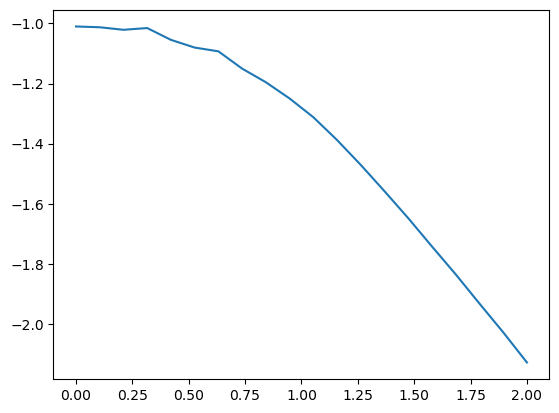

In [11]:
plt.plot(h, data_e_gs0/N)
plt.ylabel(r"$E_gs$")
plt.xlabel("h")
plt.title("L=20, TFIM")

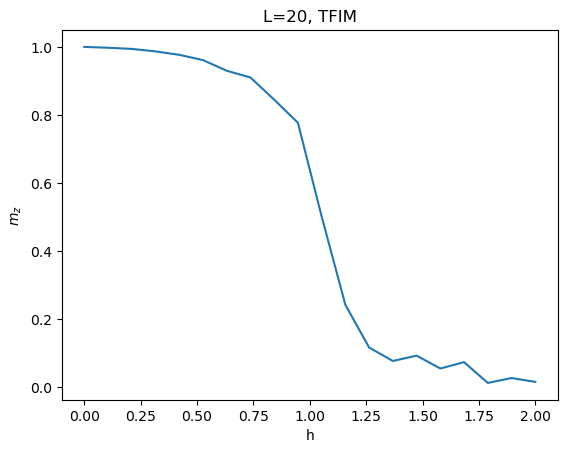

In [15]:
plt.plot(h[0:20], abs(data_m_z[0:20]))
plt.ylabel(r"$m_z$")
plt.xlabel("h")
plt.title("L=20, TFIM")
#plt.savefig("Nqs_TFIM_GCNN.pdf")